# Computational physics - Homework 3
 Francesco Emanuele Marcolini, Chiara Simonazzi, Giacomo Marcon.

 In this exercise we will apply the Mean Field method to solve the Gross-Pitaevskii equation, that describes the ground state of a quantum system of identical bosons using the Hartree–Fock approximation.

First of all, we consider the many boson case and according to the mean field approximation we express the wave function of the ground state through the one single particle function $\phi$. We consider atoms interacting via a contact potential:

$v(\hat r,\ \hat r')=4\pi \frac{{\hbar}^2}{m}a\ \delta(\hat r,\ \hat r')$

The variational method leads to the Gross-Pitaevskii equation:


$$
 \frac{1}{2} \frac{d^2}{dr^2}\phi(r) + \frac{1}{2} r^2 \phi(r) + Na(\frac{\phi(r)}{r})^2\phi(r) = \mu r
 $$ 


In [ ]:
import numpy as np
from scipy.linalg import eigh_tridiagonal
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.special import hermite
from numpy.polynomial.hermite import hermgauss
from scipy.special import factorial
from scipy.linalg import eigh
from matplotlib.ticker import StrMethodFormatter
from numpy.polynomial.hermite import hermval
from scipy.special import eval_hermite

In [ ]:
Npoints = 500
Interval = 10 
xx=np.zeros([Npoints+1])
h=Interval/(Npoints)

for j in range(Npoints+1):
    x=(j+1)*h
    xx[j]=x

# Non interative solution

To build the self-consistent solution we use the non iterative solution as the initial value. By means of the finite differences algorithm we compute the solution the ground state of the confining harmonic well multiplied by the parameter $0 \leq α \leq 1$. We will get a new potential at each step, depending on the wave function which is solution of the previous step: 
$$
v_{new}\ =\ \alpha v_{new}+ (1\ -\ \alpha)v_{old},\ \ \alpha\ \ll\ 1.
$$
This is called mixing procedure.

We then solve one iteration of the Gross-Pitaevskii equation for the ground state of a gas of cold atoms $(ℓ = 0)$.


In [ ]:
def fillH(Npoints, h, potential):
    diag_sup = np.zeros(Npoints)
    diag = np.zeros(Npoints+1)

    for j in range(Npoints+1):
        if j!=Npoints:
            diag_sup[j]= - 0.5 / h**2
        diag[j]= 1. / h**2 + potential[j]
    return diag_sup, diag

def solveH(Npoints, h, x, potential, normalize = True):
    diag_sup, diag = fillH(Npoints, h, potential)
    eigvals, eigvecs = eigh_tridiagonal(diag, diag_sup)
    gs_eigval = eigvals[0]
    gs_eigvec = eigvecs[:, 0]
    if normalize:
        norm = simpson(gs_eigvec**2, x)
        gs_eigvec = gs_eigvec / np.sqrt(norm)
    return gs_eigval, gs_eigvec

ground state energy for the noninteractive solution 1.50
normalization of the eigenstate: 1.00



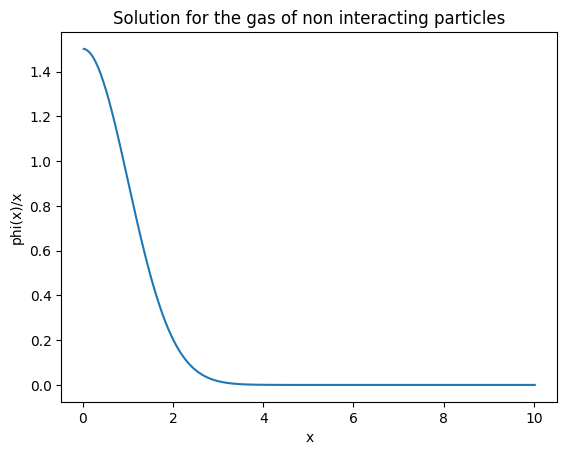

In [ ]:
phigs_noninteractive = np.zeros([Npoints+1])

def potential_noninteractive(x):
    pot=0.5*x*x   
    return pot

v, w = solveH(Npoints, h, xx, potential_noninteractive(xx))
phigs_noninteractive = w
print("ground state energy for the noninteractive solution {:.2f}".format(v))
norm_const = simpson(phigs_noninteractive**2, xx)
print("normalization of the eigenstate: {:.2f}".format(norm_const))
print("")
plt.plot(xx, phigs_noninteractive / xx)
plt.title("Solution for the gas of non interacting particles")
plt.xlabel("x")
plt.ylabel("phi(x)/x")
plt.show()

# Single iteration 

We now want to solve the full Gross-Pitaevskij equation, expressed as follows: 
$$
- \frac{1}{2} \frac{d^2}{dr^2}\phi(r) + \frac{1}{2} r^2 \phi(r) + Na(\frac{\phi(r)}{r})^2\phi(r) = \mu r
$$

Note on dimensions: the above equation as well as the results and calculations below are carried out in adimensional units, in particular: 
* Scaling factor for lenghts: $C_{len} = a_{ho} = \sqrt{\frac{\hbar}{m \omega_{ho}}}$
* scaling factor for energies: $C_{en} = \frac{\hbar^2}{m a_{ho}^2}$
* scaling factor for linear momenta: $C_{p} = \frac{\hbar}{a_{ho}}$

mu values for different alphas: 
alpha = 0.00, mu = 1.50
alpha = 0.11, mu = 1.51
alpha = 0.22, mu = 1.54
alpha = 0.33, mu = 1.59
alpha = 0.44, mu = 1.65
alpha = 0.56, mu = 1.73
alpha = 0.67, mu = 1.83
alpha = 0.78, mu = 1.93
alpha = 0.89, mu = 2.04
alpha = 1.00, mu = 2.16


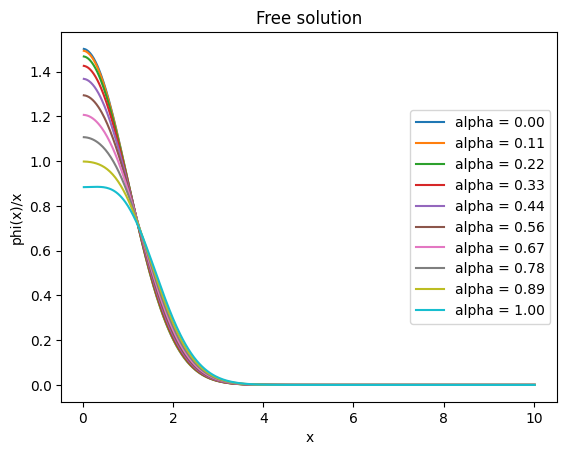

In [ ]:
# first gp iteration

Na = 1

alphas = np.linspace(0, 1, 10)
mus = np.zeros([len(alphas)])

def potential_gp_p2(x, phi, Na):
    pot = 0.5 * x * x + Na * phi * phi / x / x
    return pot

fig, ax = plt.subplots()
ax.set_title("Free solution")
ax.set_xlabel("x")
ax.set_ylabel("phi(x)/x")
for i, alpha in enumerate(alphas):
    v, w = solveH(Npoints, h, xx, potential_gp_p2(xx, phigs_noninteractive*alpha, Na))

    mus[i] = v
    ax.plot(xx, w / xx, label="alpha = {:.2f}".format(alpha))

print("mu values for different alphas: ")
for mu, alpha in zip(mus, alphas):
    print("alpha = {:.2f}, mu = {:.2f}".format(alpha, mu))

ax.legend(loc='center right')
plt.show()


The eigenvalue 𝜇 of the Gross-Pitaevskij equation does not represent the energy: it is a Lagrange multiplier. For this reason it is necessary to develop a method for determining the energy. In this homework we will establish two methods of computing the energy: from the functional or from the eigenvalue 𝜇. A comparison between the two is the criterion for the convergence of the iterating procedure.  

In [ ]:
# energy evaluators
def epstA(phi, h):
    dd_phi = np.gradient(np.gradient(phi, h), h)
    integrand = -0.5 * phi * dd_phi
    out = simpson(integrand, dx = h)
    return out

def epstB(x, phi, h): 
    integrand = 0.5 * phi * phi * x * x
    out = simpson(integrand, dx = h)
    return out

def epstC(x, phi, Na, h): 
    integrand = 0.5 * Na * phi * phi * phi * phi / x / x
    out = simpson(integrand, dx = h)
    return out

def energy1(x, phi, Na, h):
    e1 = epstA(phi, h)
    e2 = epstB(x, phi, h)
    e3 = epstC(x, phi, Na, h)
    return e1 + e2 + e3

def energy2(x, phi, Na, mu, h):
    e1 = epstC(x, phi, Na, h)
    return mu - e1

# Self consistent solution using the finite differences method

## Code

In [ ]:
# full solution
def solvegp(Npoints,
            Interval,
            Na,
            maxiter = 200,
            keepallphis = False,
            alpha = 0.05,
            treshold = 1e-4,
            plotstuff = True):
    
    xx=np.zeros([Npoints+1])
    h=Interval/(Npoints)    
    for j in range(Npoints+1):
        x=(j+1)*h
        xx[j]=x

    # defining useful functions to fill the hamiltonian
    def potential_free(x):
        pot=0.5*x*x   
        return pot

    def potential_gp(x, phi, Na):
        pot=0.5 * x * x + Na * phi * phi / x / x
        return pot

    # non interacting solution, needed for the first iteration
    phigs_free = np.zeros([Npoints+1])
    v, w = solveH(Npoints, h, xx, potential_free(xx))
    phigs_free = w

    # memory allocations
    phi = phigs_free
    potential = potential_gp(xx, phi, Na)
    if keepallphis: # if we want to keep wave functions at every iteration
        phis = np.zeros([maxiter, Npoints+1])
    mus = np.zeros([maxiter])
    e1_vec = np.zeros([maxiter])
    e2_vec = np.zeros([maxiter])
    numiter = 0

    # self consistent solution
    for count in range(maxiter):
        numiter += 1
        # potential calculation and mixing
        potential_old = potential
        potential_new = potential_gp(xx, phi, Na)
        potential = alpha * potential_new + (1-alpha) * potential_old
        # finite differences solution
        v, w = solveH(Npoints, h, xx, potential)
        phi = w
        # saving results
        if keepallphis: 
            phis[count] = phi
        mus[count] = v
        e1_vec[count] = energy1(xx, phi, Na, h)
        e2_vec[count] = energy2(xx, phi, Na, mus[count], h)
        delta = np.abs(e1_vec[count] - e2_vec[count]) # difference between energy estimators
        if delta < treshold: # if we reach the desired treshold
            break
        if count == maxiter-1: # if we reach the maximum number of iterations
            print("Warning: treshold not reached after {} iterations".format(maxiter))

    if plotstuff: 
        print("Number of iteration to comply with treshold of {}: {}".format(treshold, numiter))
        # evolution of the energy estimators and their difference
        fig, ax = plt.subplots(nrows = 2, sharex = True)
        fig.suptitle("Energy estimators. Na = {}, treshold = {}".format(Na, treshold))
        ax[0].set_ylabel("Adimensional Energy")
        ax[0].plot(e1_vec[:numiter-1], 'r--', label="Energy 1")
        ax[0].plot(e2_vec[:numiter-1], 'b--', label="Energy 2")
        ax[0].grid()
        ax[0].legend(bbox_to_anchor=(1.05, 1))
        ax[1].plot(e1_vec[:numiter-1]-e2_vec[:numiter-1], 'k-', label = "Estimators delta (last delta value: {})".format(e1_vec[numiter-1]-e2_vec[numiter-1]))
        ax[1].set_xlabel("Iteration")
        ax[1].set_ylabel("Adimensional energy")
        ax[1].grid()
        ax[1].legend(bbox_to_anchor=(1.05, 1))
        # comparison between non interacting wf and gp solution
        figphi, axphi = plt.subplots()
        figphi.suptitle("wf of non interacting system and of system with Na = {}".format(Na))
        axphi.plot(xx, phigs_free / xx, label="Non interacting solution")
        axphi.plot(xx, phi / xx, label="Na = {}".format(Na))
        axphi.legend(bbox_to_anchor=(1.05, 1))
        axphi.set_xlabel("x")
        axphi.set_ylabel("phi(x)/x")
        plt.show()
    
    out = {"gs_wf": phi,
           "gs_en1": e1_vec[numiter-1],
           "gs_en2": e2_vec[numiter-1],
           }
    if keepallphis: 
        out["gs_wf_evol"] = phis[:numiter-1,:]
        out["gs_en1"] = e1_vec[:numiter-1]
        out["gs_en2"] = e2_vec[:numiter-1]

    return out


## Results

### Analysis on the effect of different values of $\alpha$ and `Npoints`
After the initial evolution the difference between estimators stabilizes, independently of the value of the mixing paramenter $\alpha$. We think that this is due to the numerical errors in the finite differences method, as this "stable difference" significantly decreases as we increase the number of points (thus decreasing the finite derivative step $h$). We present an analysis (considering `Na` = 0.01 and 1).

In [ ]:
# WARNING: the following code takes 30 minutes to run, we present the result of the run below
# Na = 0.01
# alpha_mesh = np.arange(0.001, 1, (1-0.001) / 10.)
# Npoints_mesh = np.arange(100, 1000, 100, dtype = int)
# res_matrix = np.zeros([len(alpha_mesh), len(Npoints_mesh)])
# for i, alpha in enumerate(alpha_mesh):
#     for j, Npoints in enumerate(Npoints_mesh):
#         print("alpha = {:.2f} (iteration {}), Npoints = {} (iteration {})".format(alpha, i, Npoints, j))
#         out = solvegp(Npoints, Interval, Na, treshold = 0, maxiter = 1000, alpha = alpha, plotstuff=False) # Note: based on previous runs, 1000 iterations is enough to reach convergence with all values of alpha and Npoints
#         res_matrix[i, j] = np.abs(out["gs_en1"] - out["gs_en2"])

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

# fig, ax = plt.subplots()

# im, cbar = heatmap(res_matrix, alpha_mesh, Npoints_mesh, ax=ax, cbarlabel="energy delta", vmin = 1e-5, vmax = 1e-3)
# texts = annotate_heatmap(im, valfmt="{x:.2e}", fontsize = 6)

# fig.tight_layout()
# plt.show()

Na = 0.01

![title](finitediff_heatmap_001.png)

In [ ]:
# WARNING: the following code takes 30 minutes to run, we present the result of the run below
# Na = 1
# alpha_mesh = np.arange(0.001, 1, (1-0.001) / 10.)
# Npoints_mesh = np.arange(100, 1000, 100, dtype = int)
# res_matrix = np.zeros([len(alpha_mesh), len(Npoints_mesh)])
# for i, alpha in enumerate(alpha_mesh):
#     for j, Npoints in enumerate(Npoints_mesh):
#         print("alpha = {:.2f} (iteration {}), Npoints = {} (iteration {})".format(alpha, i, Npoints, j))
#         out = solvegp(Npoints, Interval, Na, treshold = 0, maxiter = 1000, alpha = alpha, plotstuff=False) # Note: based on previous runs, 1000 iterations is enough to reach convergence with all values of alpha and Npoints
#         res_matrix[i, j] = np.abs(out["gs_en1"] - out["gs_en2"])

In [ ]:
# fig, ax = plt.subplots()

# im, cbar = heatmap(res_matrix, alpha_mesh, Npoints_mesh, ax=ax, cbarlabel="energy delta", vmin = 1e-5, vmax = 1e-3)
# texts = annotate_heatmap(im, valfmt="{x:.2e}", fontsize = 6)

# fig.tight_layout()
# plt.show()

Na = 1

![title](finitediff_heatmap_1.png)

Considering reasonable values of `alpha` and `Npoints`

### Na = 0.01

Number of iteration to comply with treshold of 0.0001: 500


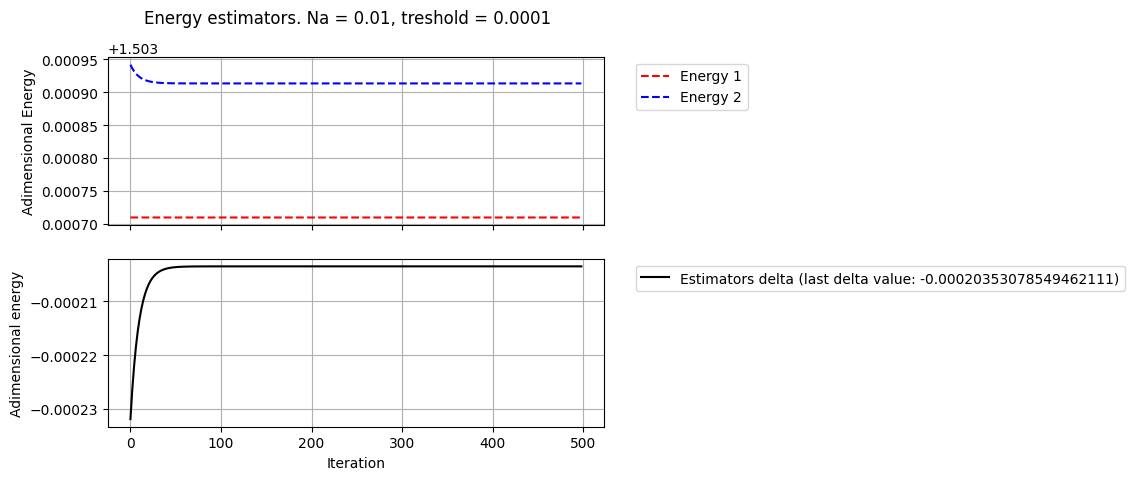

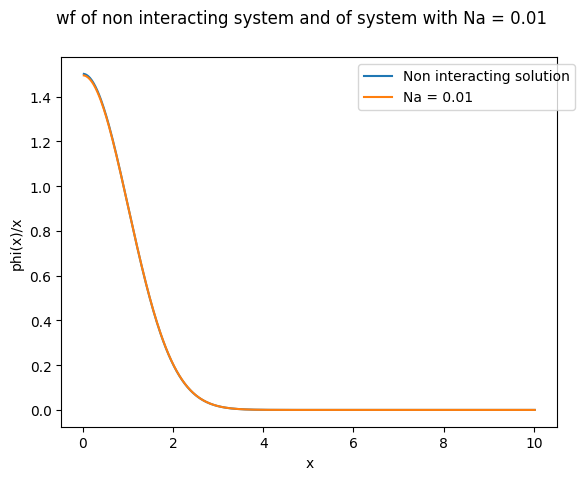

In [ ]:
Na001_Npoints = 500
Na001_alpha = 0.1
Na = .01
Na001_treshold = 1e-4
Na001_maxiter = 500
Interval = 10

out = solvegp(Na001_Npoints, Interval, Na, treshold = Na001_treshold, maxiter = Na001_maxiter, alpha = Na001_alpha)

### Na = 1

Considering reasonable values of `alpha` and `Npoints`

Number of iteration to comply with treshold of 0.0001: 500


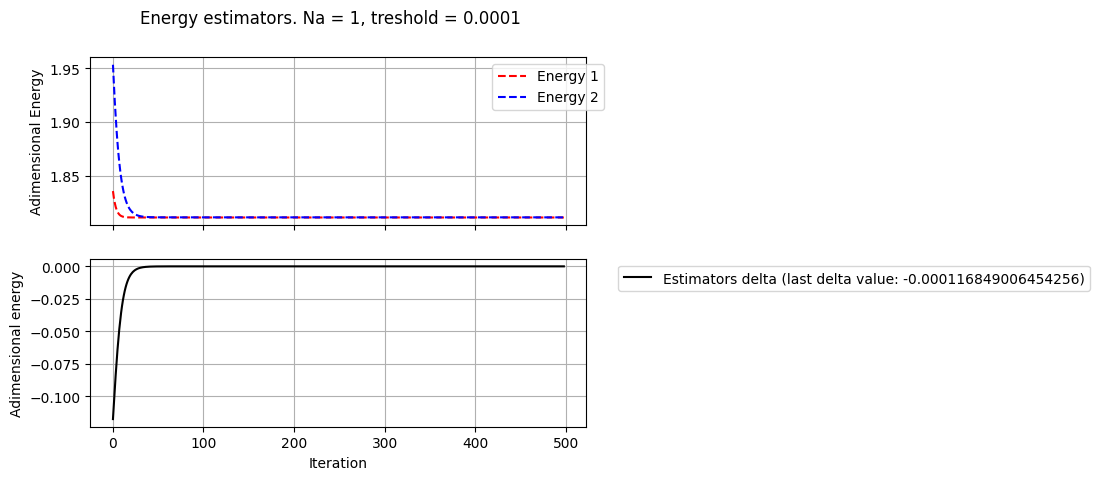

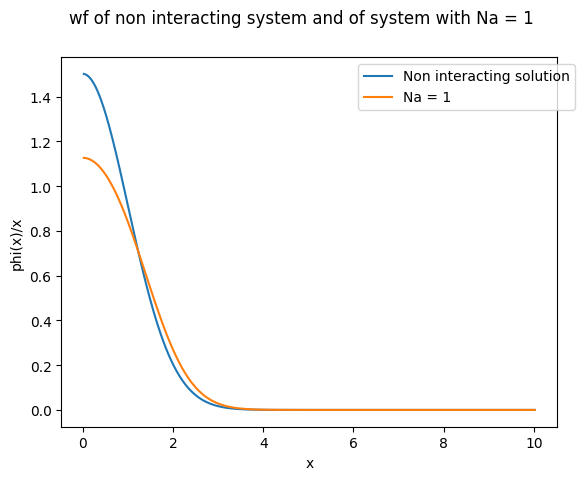

In [ ]:
Na = 1
Na1_alpha = 0.1
Na1_treshold = 1e-4
Na1_Npoints = 500
Na1_maxiter = 500
Interval = 10

out = solvegp(Na1_Npoints, Interval, Na, treshold = Na1_treshold, maxiter = Na1_maxiter, alpha = Na1_alpha)

### Na = 100

In this case we see how the dependence on the mixing parameter $\alpha$ is much more significant, as with a big value of $\alpha$ we see the oscillations of the solutions as discussed in class

Number of iteration to comply with treshold of 1e-05: 500


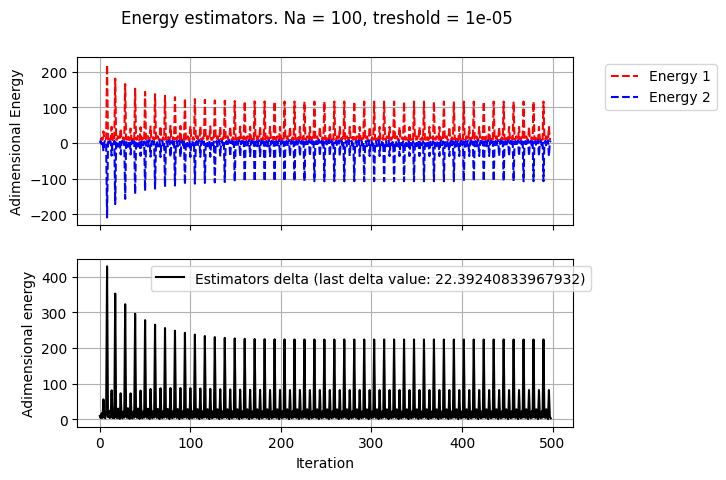

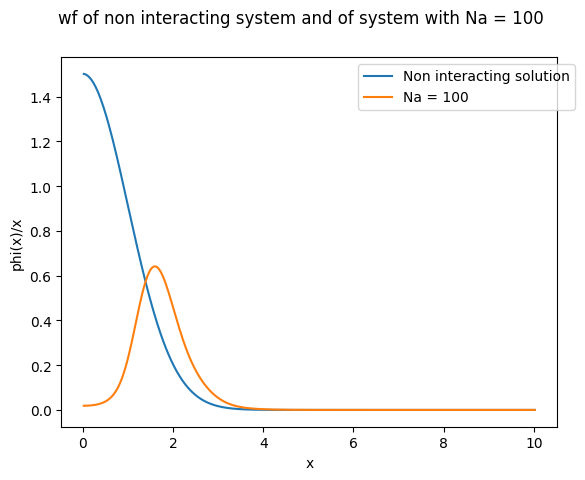

In [ ]:
Na = 100
Na100_alpha = 0.5
Na100_treshold = 1e-5
Na100_Npoints = 500
Na100_maxiter = 500
Interval = 10

out = solvegp(Na100_Npoints, Interval, Na, treshold = Na100_treshold, maxiter = Na100_maxiter, alpha = Na100_alpha)

Number of iteration to comply with treshold of 1e-05: 500


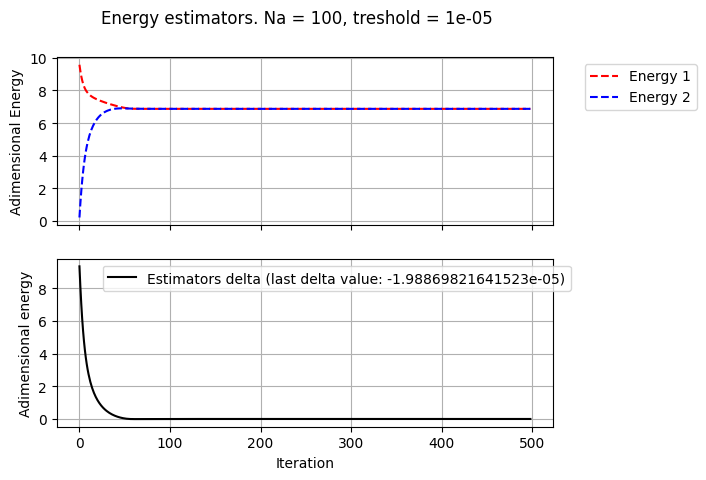

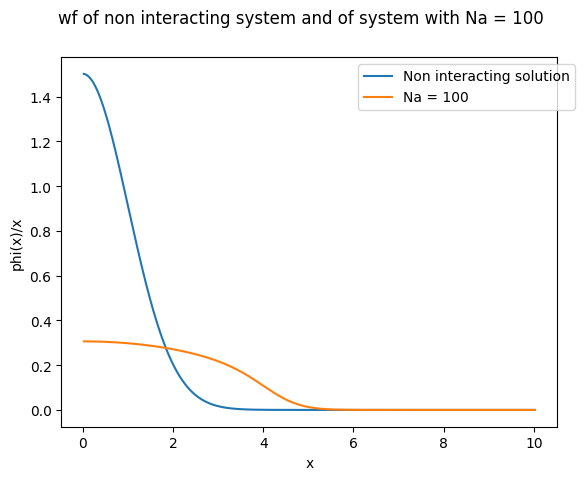

In [ ]:
Na = 100
Na100_alpha = 0.05
Na100_treshold = 1e-5
Na100_Npoints = 500
Na100_maxiter = 500
Interval = 10

out = solvegp(Na100_Npoints, Interval, Na, treshold = Na100_treshold, maxiter = Na100_maxiter, alpha = Na100_alpha)

# Self consistent solution using the variational method

Note: We use gauss hermite quadrature to evaluate the interaction part of the potential, as proposed in the homework on variational method. 

## Code

In [ ]:
# auxillary functions to compute the eigenstates and the potential
def Cn(n):
    return 1 / np.sqrt(2**(2*n) * factorial(2*n+1) * np.sqrt(np.pi))

Cn_vec = np.vectorize(Cn)

def basisstate(n, x):
    return Cn(n) * hermite(2*n+1)(x) * np.exp(-x**2/2)

def generatestate(w, basissize, x):
    y = np.zeros_like(x)
    for i in range(basissize):
        y += w[i] * basisstate(i, x)
    return y

# def Ufunc_interaction(w, m, n):
#     basissize = len(w)
#     deg_poly = 2*n+2*m+2+4*basissize
#     deg_py = int(np.ceil((deg_poly*2+1) / 2 / 3))
#     hg_sp, hg_w = hermgauss(deg_py)

#     def sample_U(w, m, n, x):
#         constants = Cn_vec(np.arange(basissize))
#         sqrt_2 = np.sqrt(2)
#         if x == 0:
#             def divide_hermite(deg, x):
#                 coef = hermite(deg).coef
#                 return np.polyval(coef[:-1], x)
#             herm_arr = np.array([divide_hermite(2*i + 1, x / sqrt_2) for i in range(basissize)])
#         else: 
#             herm_arr = np.array([eval_hermite(2*i + 1, x / sqrt_2) / (x / sqrt_2 ) for i in range(basissize)])
#         sqrt_density = (w * constants * herm_arr).sum()
#         return 1 / 2 / sqrt_2 * Cn(n) * Cn(m) *\
#             eval_hermite(2*n+1, x / sqrt_2) * eval_hermite(2*m+1, x / sqrt_2) *\
#             sqrt_density * sqrt_density 
    
#     hg_vals = np.array([sample_U(w, m, n, x) for x in hg_sp])
#     return np.dot(hg_vals, hg_w)

def Ufunc_interaction(w, m, n):
    basissize = len(w)
    constants = Cn_vec(np.arange(basissize))

    all_weights = np.zeros(2*basissize+1) # vettore di pesi da passare alla serie di hermite
    for i in range(basissize):
        all_weights[2*i+1] = w[i] * constants[i]

    deg_poly = 2*n+2*m+2+4*basissize
    deg_py = int(np.ceil((deg_poly*2+1) / 2 / 3))
    hg_sp, hg_w = hermgauss(deg_py)

    def sample_U(w, m, n, x):
        sqrt_2 = np.sqrt(2)
        if x == 0:
            def divide_hermite(deg, x):
                coef = hermite(deg).coef
                return np.polyval(coef[:-1], x)
            herm_arr = np.array([divide_hermite(2*i + 1, x / sqrt_2) for i in range(basissize)])
            sqrt_density = (w * constants * herm_arr).sum()
        else:
            sqrt_density = hermval(x / sqrt_2, all_weights) / (x / sqrt_2)
        return 1 / 2 / sqrt_2 * Cn(n) * Cn(m) *\
            eval_hermite(2*n+1, x / sqrt_2) * eval_hermite(2*m+1, x / sqrt_2) *\
            sqrt_density * sqrt_density 
    
    hg_vals = np.array([sample_U(w, m, n, x) for x in hg_sp])
    return np.dot(hg_vals, hg_w)


def genH(basissize, w, Na, U_interaction_matrix_old, alpha):
    H = np.zeros((basissize, basissize))
    U_interaction_matrix = np.zeros((basissize, basissize))
    for i in range(basissize):
        for j in range(basissize):
            toinsert = 0
            if i == j:
                toinsert =+ (0.5 + 2*i + 1)
            U_interaction_matrix[i, j] = alpha * (Ufunc_interaction(w, i, j)) + (1-alpha) * U_interaction_matrix_old[i, j]
            toinsert += Na * U_interaction_matrix[i, j]
            H[i,j] = toinsert
    return H,  U_interaction_matrix

In [ ]:
# full solution
def solvegp(basissize,
            Interval,
            Na,
            maxiter = 200,
            alpha = 0.05,
            treshold = 1e-4,
            interval_points = 1000,
            plotstuff = True,
            keepallphis = False):
    
    xx=np.zeros([interval_points+1])
    h=Interval/(interval_points)    
    for j in range(interval_points+1):
        x=(j+1)*h
        xx[j]=x

    # weights array (initialized to [1, 0, ..., 0]) representing the starting solution (gs of the harmonic oscillator)    
    w_nonint = np.zeros(basissize)
    w_nonint[0] = 1
    w = w_nonint

    # memory allocations
    U_interaction_matrix = np.zeros((basissize, basissize))
    if keepallphis: # if we want to keep wave functions at every iteration
        phis = np.zeros([maxiter, Npoints+1])
    mus = np.zeros([maxiter])
    e1_vec = np.zeros([maxiter])
    e2_vec = np.zeros([maxiter])
    numiter = 0

    # self consistent solution
    H, U_interaction_matrix = genH(basissize, w, Na, U_interaction_matrix, alpha)
    for count in range(maxiter):
        numiter += 1
        #print(numiter)
        # potential calculation and mixing
        if alpha == "adaptive":
            alpha_val = max((1 / 3 / np.sqrt(count+1)), 0.01)
            H, U_interaction_matrix = genH(basissize, w, Na, U_interaction_matrix, alpha_val)
        else: 
            H, U_interaction_matrix = genH(basissize, w, Na, U_interaction_matrix, alpha)
        # Solving the variational problem 
        eigvals, eigvecs = eigh(H)
        w = eigvecs[:, 0]
        phi = generatestate(w, basissize, xx)
        # saving results
        if keepallphis: 
            phis[count] = phi
        mus[count] = eigvals[0]
        e1_vec[count] = energy1(xx, phi, Na, h)
        e2_vec[count] = energy2(xx, phi, Na, mus[count], h)
        delta = np.abs(e1_vec[count] - e2_vec[count]) # difference between energy estimators
        if delta < treshold: # if we reach the desired treshold
            break
        if count == maxiter-1: # if we reach the maximum number of iterations
            print("Warning: treshold not reached after {} iterations".format(maxiter))

    if plotstuff: 
        print("Number of iteration to comply with treshold of {}: {}".format(treshold, numiter))
        # evolution of the energy estimators and their difference
        fig, ax = plt.subplots(nrows = 2, sharex = True)
        fig.suptitle("Energy estimators. Na = {}, treshold = {}".format(Na, treshold))
        ax[0].set_ylabel("Adimensional Energy")
        ax[0].plot(e1_vec[:numiter-1], 'r--', label="Energy 1")
        ax[0].plot(e2_vec[:numiter-1], 'b--', label="Energy 2")
        ax[0].grid()
        ax[0].legend(bbox_to_anchor=(1.05, 1))
        ax[1].plot(e1_vec[:numiter-1]-e2_vec[:numiter-1], 'k-', label = "Estimators delta (last delta value: {})".format(e1_vec[numiter-1]-e2_vec[numiter-1]))
        ax[1].set_xlabel("Iteration")
        ax[1].set_ylabel("Adimensional energy")
        ax[1].grid()
        ax[1].legend(bbox_to_anchor=(1.05, 1))
        # comparison between non interacting wf and gp solution
        figphi, axphi = plt.subplots()
        figphi.suptitle("wf of non interacting system and of system with Na = {}".format(Na))
        axphi.plot(xx, generatestate(w_nonint, basissize, xx) / xx, label="Non interacting solution")
        axphi.plot(xx, phi / xx, label="Na = {}".format(Na))
        axphi.legend(bbox_to_anchor=(1.05, 1))
        axphi.set_xlabel("x")
        axphi.set_ylabel("phi(x)/x")
        plt.show()
    
    out = {"gs_wf": phi,
           "gs_en1": e1_vec[numiter-1],
           "gs_en2": e2_vec[numiter-1],
           }
    if keepallphis: 
        out["gs_wf_evol"] = phis[:numiter-1,:]
        out["gs_en1"] = e1_vec[:numiter-1]
        out["gs_en2"] = e2_vec[:numiter-1]

    return out


## Results

### Na = 0.01

Number of iteration to comply with treshold of 0.0001: 36


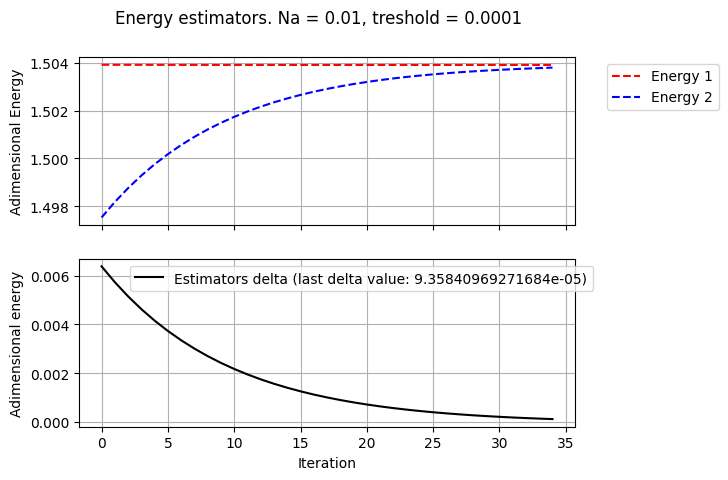

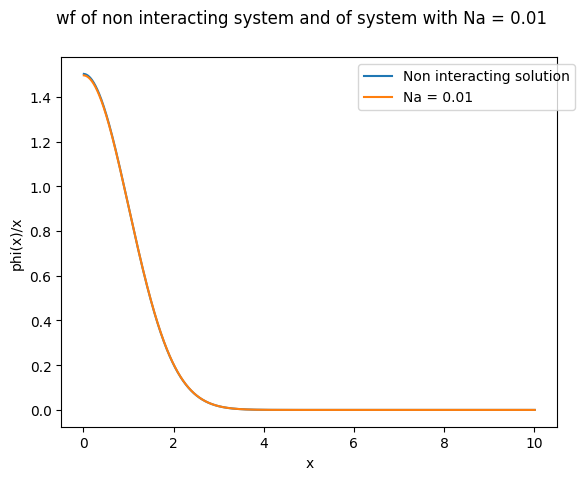

{'gs_wf': array([ 1.49568468e-02,  2.99092452e-02,  4.48527487e-02, ...,
        -5.80687624e-19, -5.30563899e-19, -4.84712723e-19]),
 'gs_en1': 1.5039099974755843,
 'gs_en2': 1.5038164133786571}

In [ ]:
solvegp(5, 10, .01, maxiter = 200, alpha = 0.1, treshold = 1e-4, plotstuff = True, keepallphis = False)


### Na = 0.1

Number of iteration to comply with treshold of 0.0001: 56


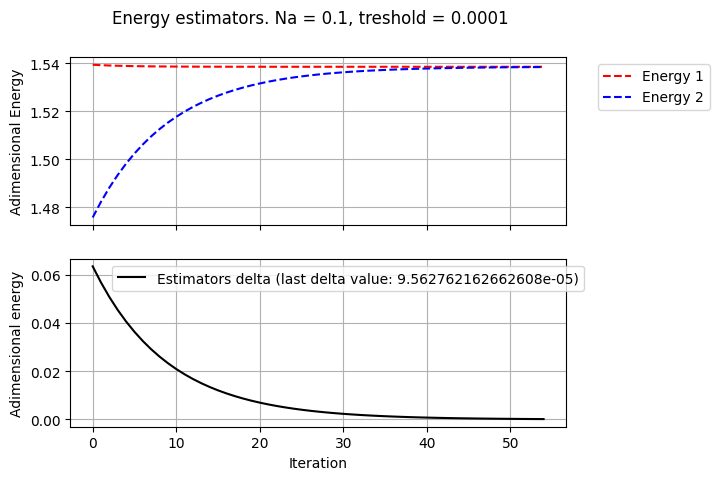

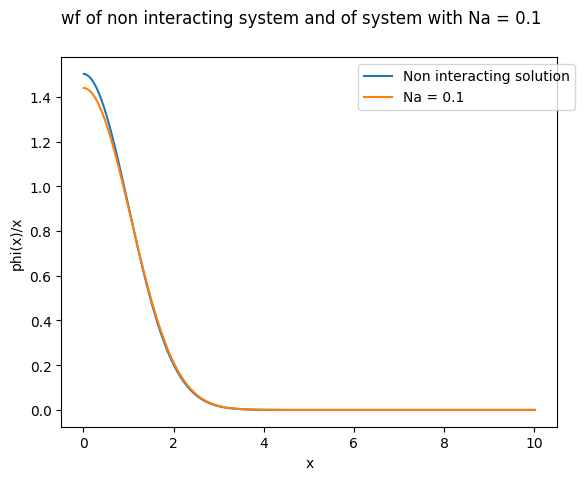

{'gs_wf': array([1.43938948e-02, 2.87838494e-02, 4.31659250e-02, ...,
        6.57361531e-15, 6.07951830e-15, 5.62183536e-15]),
 'gs_en1': 1.5385005124987927,
 'gs_en2': 1.538404884877166}

In [ ]:
solvegp(10, 10, .1, maxiter = 200, alpha = 0.1, treshold = 1e-4, plotstuff = True, keepallphis = False)


### Na = 1

Number of iteration to comply with treshold of 0.0001: 71


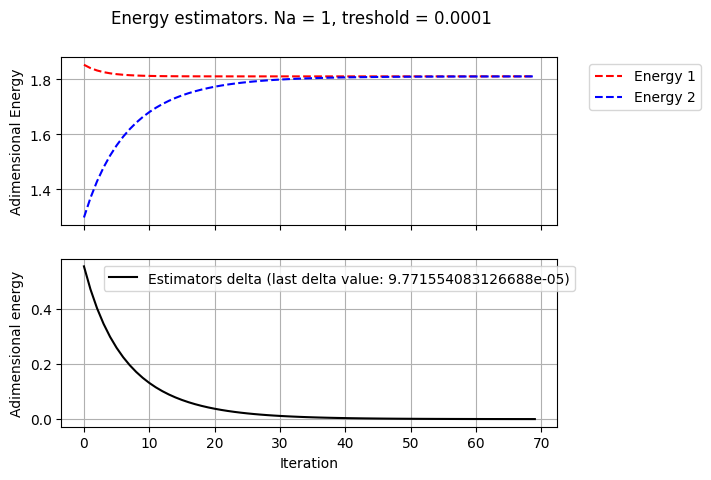

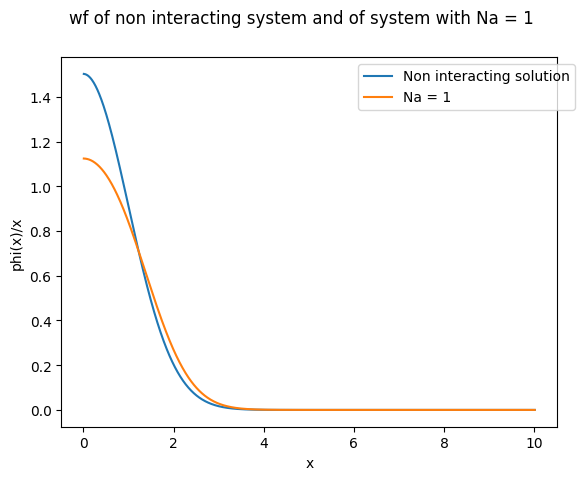

{'gs_wf': array([1.12395571e-02, 2.24774039e-02, 3.37118298e-02, ...,
        3.48945274e-18, 3.18611052e-18, 2.90882003e-18]),
 'gs_en1': 1.8111867550531466,
 'gs_en2': 1.8110890395123154}

In [ ]:
solvegp(5, 10, 1, maxiter = 200, alpha = 0.1, treshold = 1e-4, plotstuff = True, keepallphis = False)


### Na = 10

Number of iteration to comply with treshold of 0.0001: 93


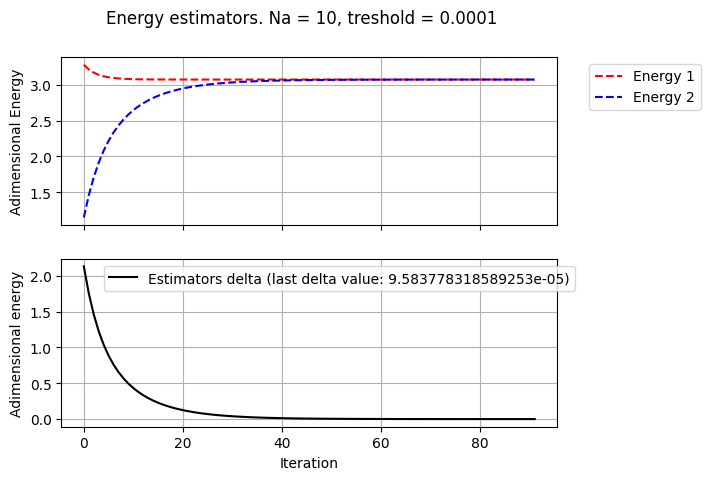

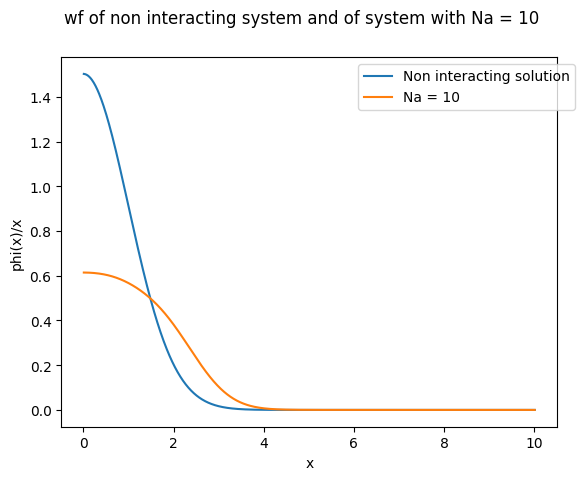

{'gs_wf': array([6.14200080e-03, 1.22837863e-02, 1.84251410e-02, ...,
        3.57787187e-16, 3.27644199e-16, 3.00006485e-16]),
 'gs_en1': 3.072124466386822,
 'gs_en2': 3.0720286286036362}

In [ ]:
solvegp(6, 10, 10, maxiter = 100, alpha = 0.1, treshold = 1e-4, plotstuff = True, keepallphis = False)

### Na = 100

Number of iteration to comply with treshold of 0.0001: 30


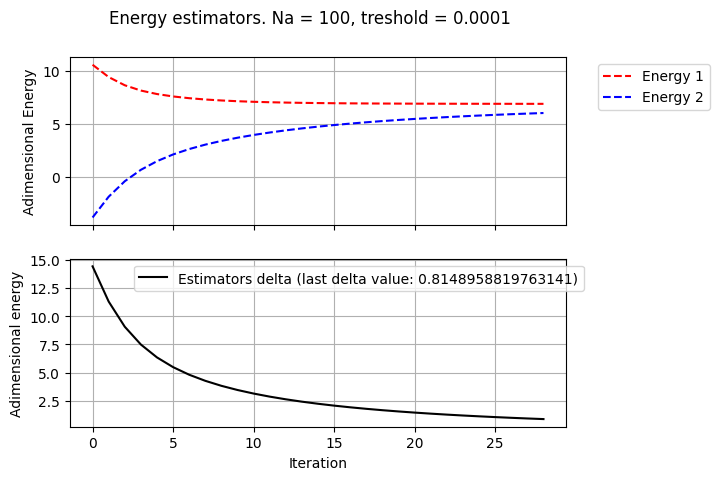

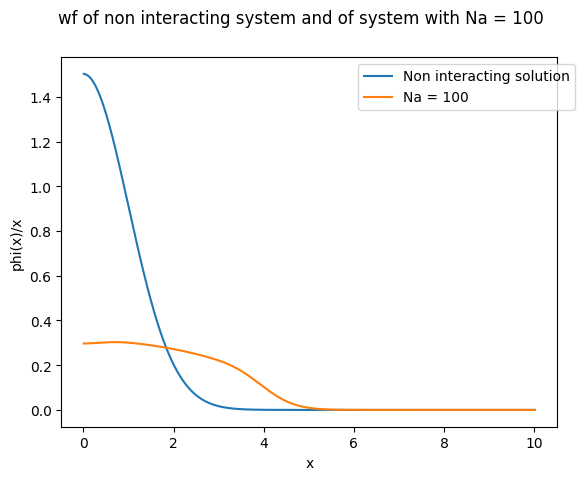

{'gs_wf': array([ 2.97046620e-03,  5.94111974e-03,  8.91214729e-03, ...,
        -1.53054935e-11, -1.41872156e-11, -1.31489021e-11]),
 'gs_en1': 6.880073158062597,
 'gs_en2': 6.065177276086283}

In [ ]:
solvegp(11, 10, 100, maxiter = 30, alpha = 0.05, treshold = 1e-4, plotstuff = True, keepallphis = False)

### Negative values of Na

Number of iteration to comply with treshold of 0.0001: 52


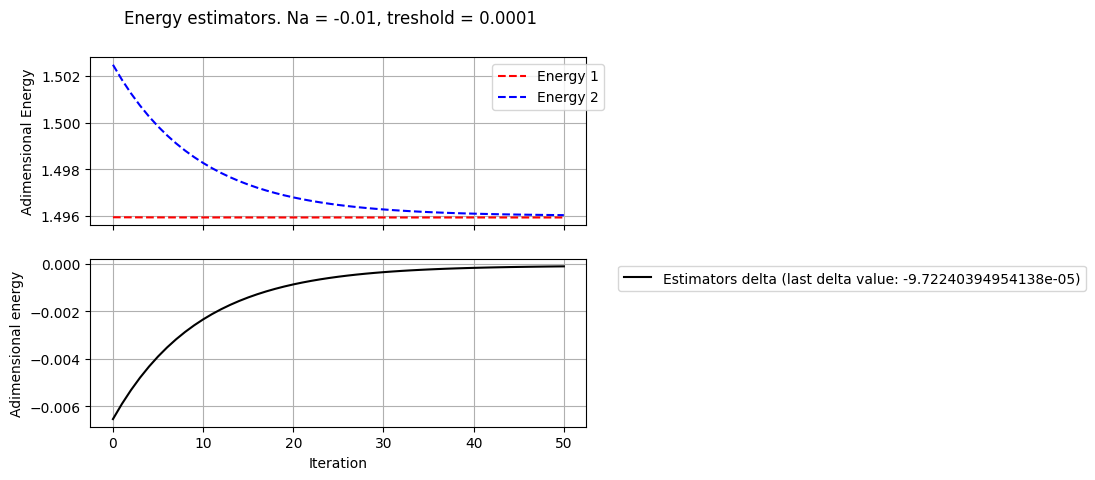

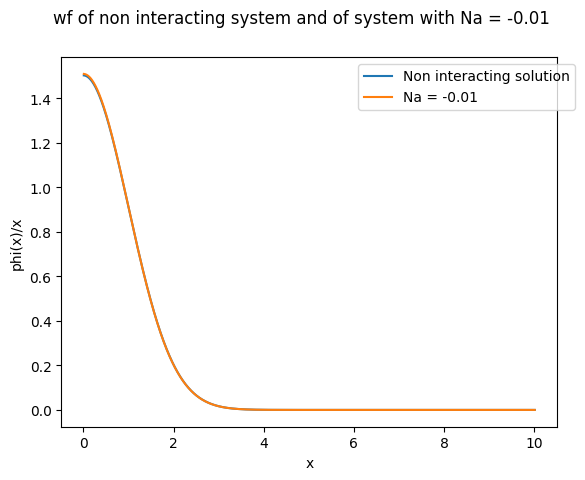

{'gs_wf': array([1.50887968e-02, 3.01730276e-02, 4.52481286e-02, ...,
        6.28261642e-19, 5.73977427e-19, 5.24325606e-19]),
 'gs_en1': 1.495929737057328,
 'gs_en2': 1.4960269610968233}

In [ ]:
solvegp(5, 10, -.01, maxiter = 200, alpha = 0.1, treshold = 1e-4, plotstuff = True, keepallphis = False)

Number of iteration to comply with treshold of 0.0001: 79


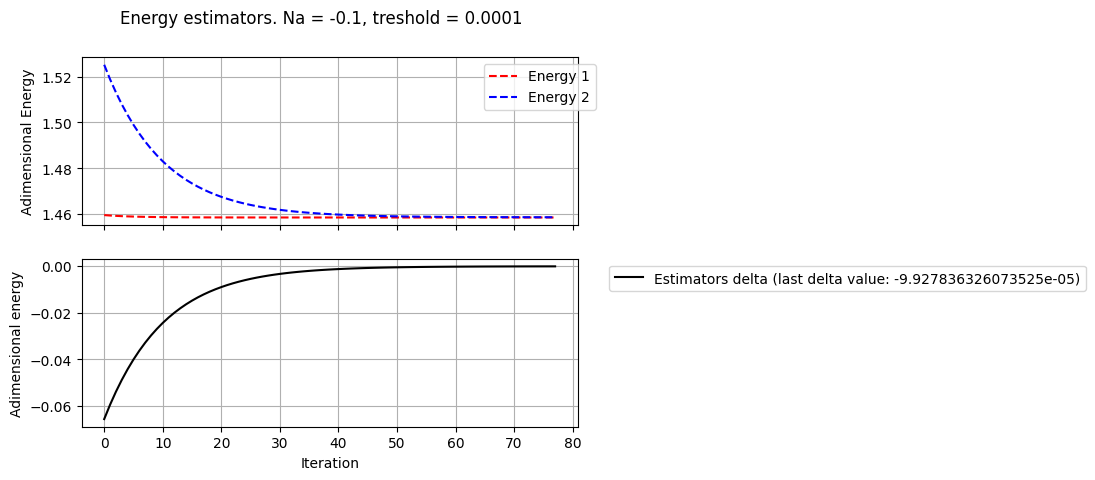

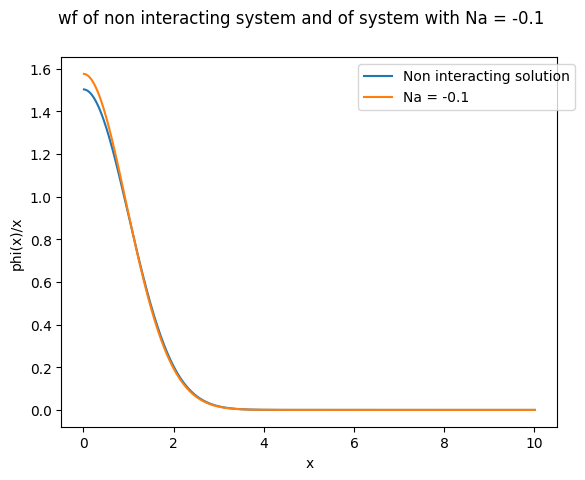

{'gs_wf': array([1.57490866e-02, 3.14930028e-02, 4.72265815e-02, ...,
        7.98780486e-18, 7.29782761e-18, 6.66671037e-18]),
 'gs_en1': 1.458499476606701,
 'gs_en2': 1.4585987549699617}

In [ ]:
solvegp(5, 10, -.1, maxiter = 200, alpha = 0.1, treshold = 1e-4, plotstuff = True, keepallphis = False)

Number of iteration to comply with treshold of 0.0001: 200


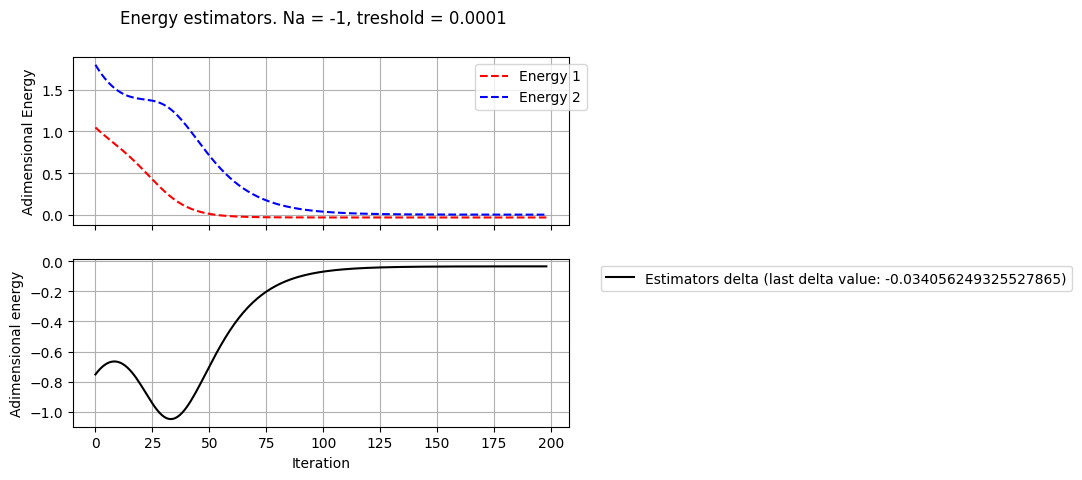

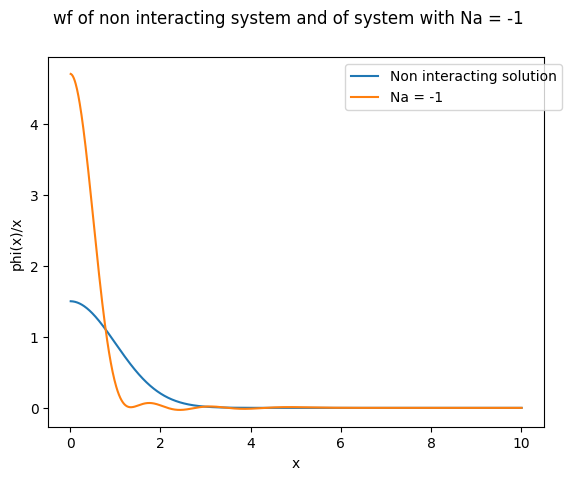

{'gs_wf': array([4.70480470e-02, 9.40371691e-02, 1.40908545e-01, ...,
        2.26771091e-13, 2.08111888e-13, 1.90965743e-13]),
 'gs_en1': -0.03129700941036262,
 'gs_en2': 0.002759239915165246}

In [ ]:
solvegp(7, 10, -1, maxiter = 200, alpha = 0.1, treshold = 1e-4, plotstuff = True, keepallphis = False)

Number of iteration to comply with treshold of 0.0001: 200


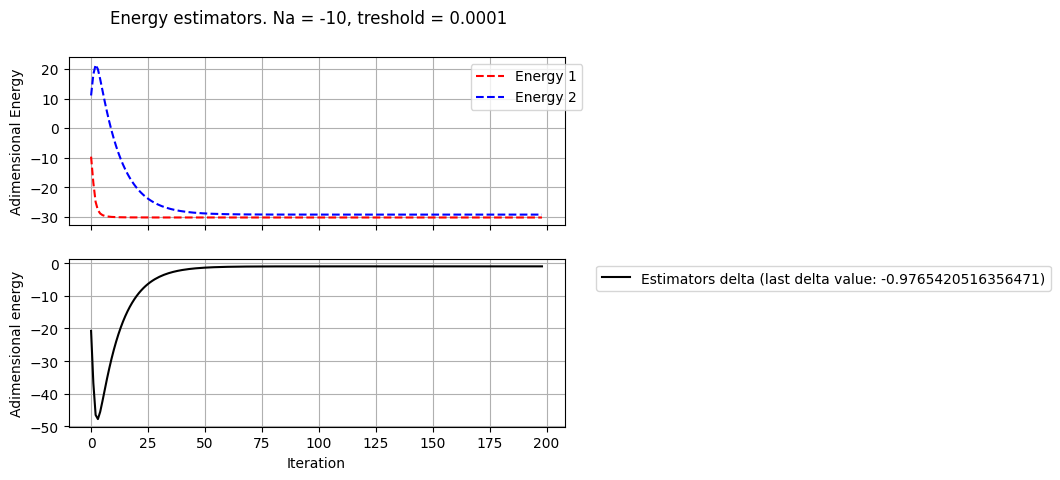

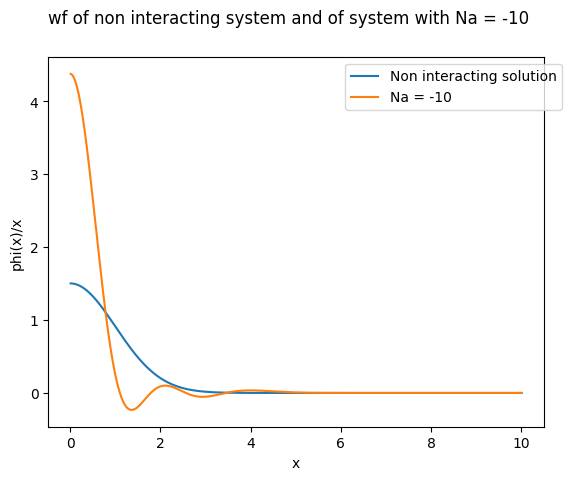

{'gs_wf': array([4.37360368e-02, 8.74228661e-02, 1.31011351e-01, ...,
        2.40784606e-15, 2.19963041e-15, 2.00919773e-15]),
 'gs_en1': -30.288357077948362,
 'gs_en2': -29.311815026312715}

In [ ]:
solvegp(5, 10, -10, maxiter = 200, alpha = 0.1, treshold = 1e-4, plotstuff = True, keepallphis = False)
# solvegp(5, 10, -100, maxiter = 200, alpha = 0.1, treshold = 1e-4, plotstuff = True, keepallphis = False)

# Conclusions

To add some final observations, we first want to highlight the different behaviour of $a>0$ and $a< 0$. In the first case the interaction is repulsive and by increasing $|a|$ we observe a decrease in the values ​​of the wave function at small $r$. In the attractive case the general behaviour is exactly the opposite.
We also noticed that the variational method in the case of Na = $\pm$100 appears to have a high time complexity. This can be explained by the necessity of considering a high number of basis elements.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8e4126dc-f129-4e98-a27d-950fd08f732c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>